### Classifying MNIST digits using dl2

In [1]:
import dl2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from IPython.display import Image
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train_oh, y_test_oh = dl2.onehot(y_train, 10), dl2.onehot(y_test, 10)
x_train_MLP, x_test_MLP = np.reshape(x_train, (60000, 784)) / 255.0, np.reshape(x_test, (10000, 784)) / 255.0
x_train_CNN, x_test_CNN = np.expand_dims(x_train, 3), np.expand_dims(x_test, 3)

### Viewing training data

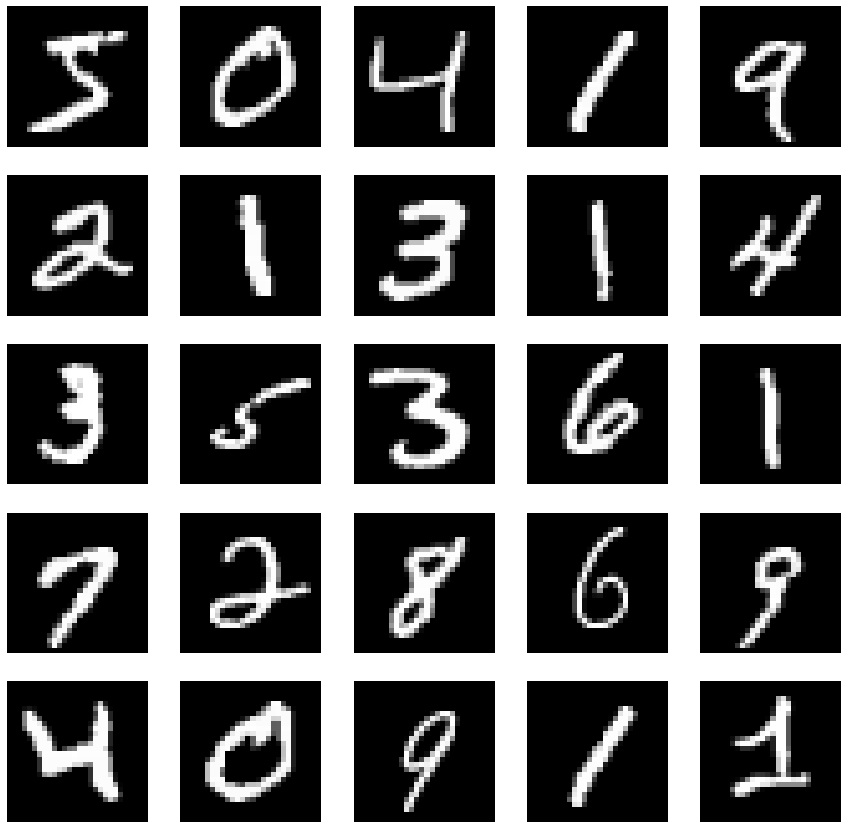

In [3]:
fig = plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray')
plt.show()

### t-SNE: t-Distributed Stochastic Neighbor Embedding
t-SNE is a way to visualize higher-dimensional data sets. The algorithm was discovered by Geoffrey Hinton. Below, we have visualised the MNIST data set in 2D - $f:\mathbb{R}^{784}\rightarrow\mathbb{R}^2$. There are 10 classes and accordingly we see 10 clusters.

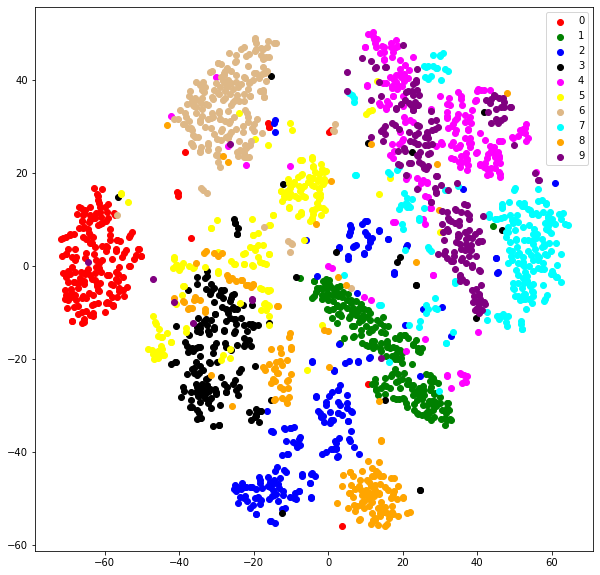

In [4]:
x = x_train_MLP[:2000]
tSNE_model = TSNE(n_components=2, random_state=0)
x2D = tSNE_model.fit_transform(x)
target_ids = range(10)
colors = 'red', 'green', 'blue', 'black', 'magenta', 'yellow', 'burlywood', 'cyan', 'orange', 'purple'
target_names = '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
plt.figure(figsize=(10, 10))
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(x2D[y_train[:2000] == i, 0], x2D[y_train[:2000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

### Gradient descent optimizers

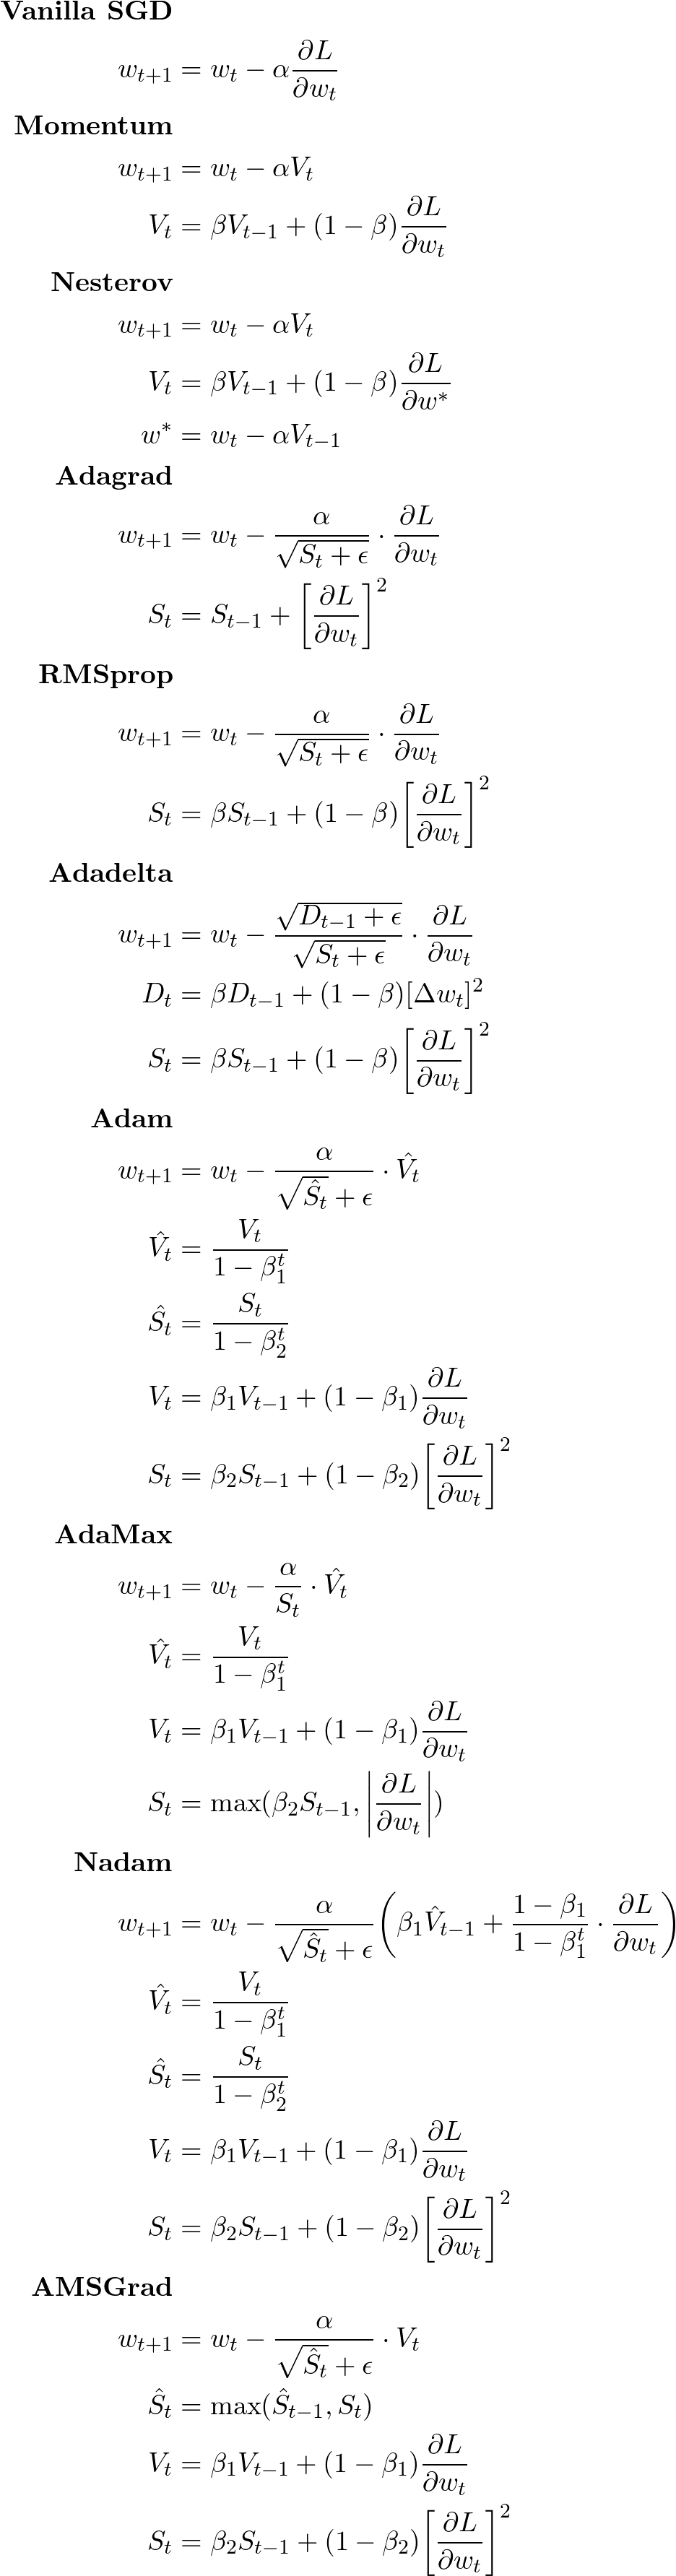

In [5]:
Image(filename='gdoptimizers.png')

Loss landscapes can get VERY complicated...we need clever ways to navigate to a local minima...hence the need for GD optimizers!

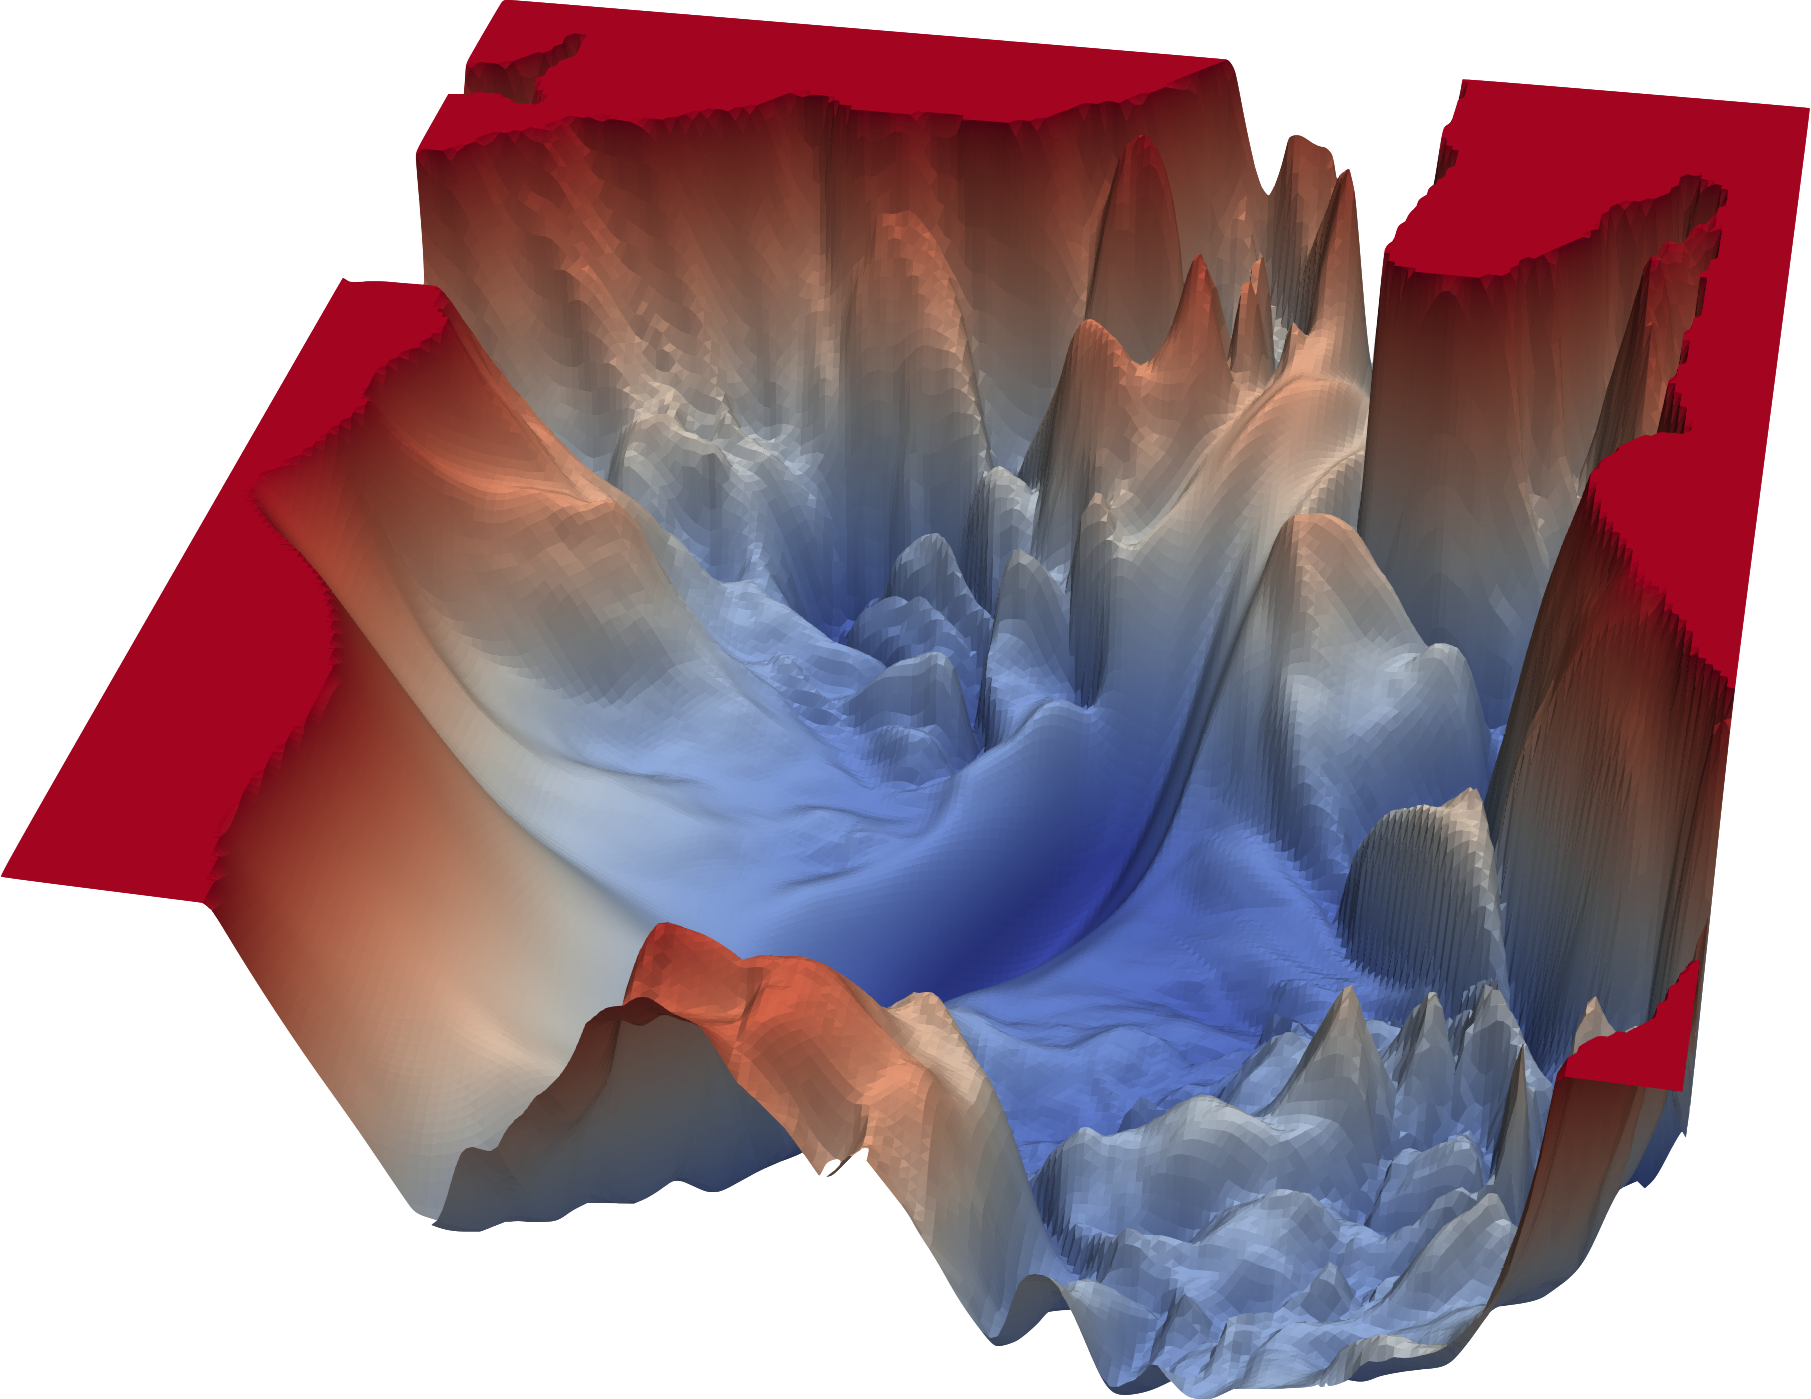

In [6]:
Image(filename='llscp.png')

The above is a portion of the loss landscape of a ResNet-110 model trained on cifar10. As we see, the landscape is ridiculously complicated...

### Plot history

In [7]:
def plot(fig, history):
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot([np.sum(loss) for loss in history['losses']])
    plt.subplot(2, 1, 2)
    plt.plot([np.sum(last_layer_grad) for last_layer_grad in history['last_layer_grads']])

### Using MLPs 
Vanilla neural networks! The MLP model used below has 41700 parameters. 

In [8]:
mlp = dl2.NN()
mlp.add(dl2.dense(50, input_dim=(784), activation='relu'))
mlp.add(dl2.dense(40, activation='relu'))
mlp.add(dl2.dense(10, activation='softmax'))
mlp.init()
mlp.info()

{'input_dim': 784, 'output_dim': 50, 'layer': 'dense', 'activation': 'relu'}
{'input_dim': 50, 'output_dim': 40, 'layer': 'dense', 'activation': 'relu'}
{'input_dim': 40, 'output_dim': 10, 'layer': 'dense', 'activation': 'softmax'}
trainable parameters: 41700


In [9]:
W, B = mlp.W, mlp.B # store initial weights and biases
mlp.loss_fn = 'ce'

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:41<00:00, 1460.80it/s]


accuracy - 90.3 %


<Figure size 720x720 with 0 Axes>

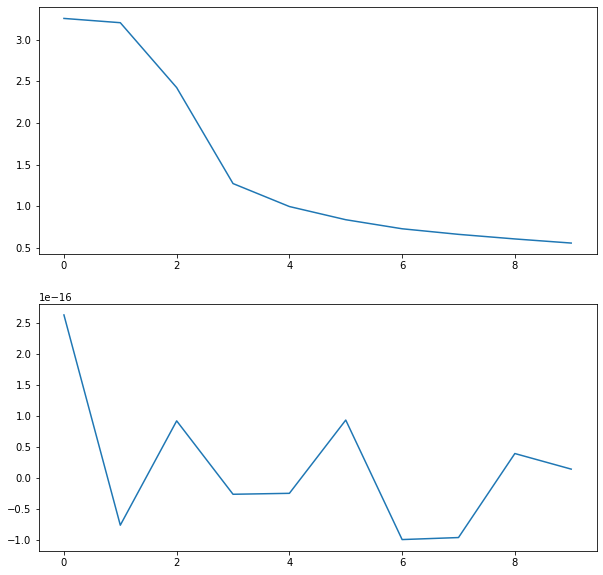

In [10]:
# Batch GD
mlp.clear_history()
mlp.W, mlp.B = W, B
mlp.opt = dl2.SGD(mlp.params(), 1e-2, 0)
plot(plt.figure(figsize=(10, 10)), mlp.fit(x_train_MLP, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(mlp, x_test_MLP, y_test_oh)} %')

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:38<00:00, 1544.45it/s]


accuracy - 96.92 %


<Figure size 720x720 with 0 Axes>

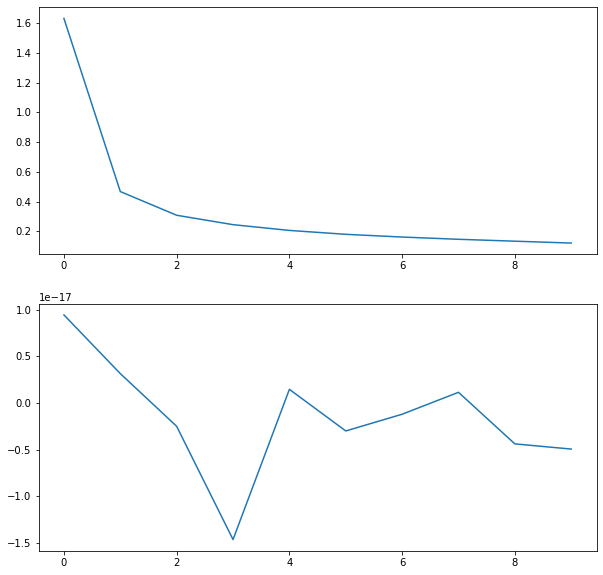

In [11]:
# Momentum 
mlp.clear_history()
mlp.W, mlp.B = W, B
mlp.opt = dl2.SGD(mlp.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), mlp.fit(x_train_MLP, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(mlp, x_test_MLP, y_test_oh)} %')

 58%|██████████████████████████████████████████▉                               | 34822/60000 [00:22<00:16, 1534.86it/s]C:\Users\rgbka\Desktop\Projects\dl2.py:462: RuntimeWarning: divide by zero encountered in log
  return - y * np.log(self.L[-1]) - (1 - y) * np.log(1 - self.L[-1])
C:\Users\rgbka\Desktop\Projects\dl2.py:462: RuntimeWarning: invalid value encountered in multiply
  return - y * np.log(self.L[-1]) - (1 - y) * np.log(1 - self.L[-1])
100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:00<00:00, 987.91it/s]


accuracy - 96.11 %


<Figure size 720x720 with 0 Axes>

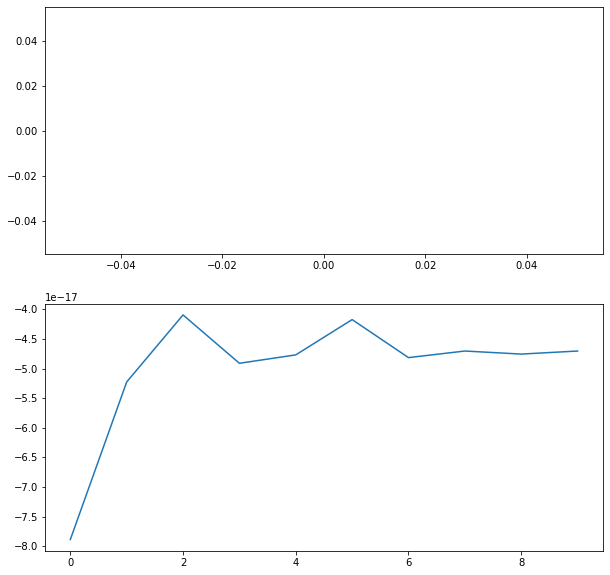

In [12]:
# RMSprop
mlp.clear_history()
mlp.W, mlp.B = W, B
mlp.opt = dl2.RMSprop(mlp.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), mlp.fit(x_train_MLP, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(mlp, x_test_MLP, y_test_oh)} %')

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:03<00:00, 945.71it/s]


accuracy - 95.8 %


<Figure size 720x720 with 0 Axes>

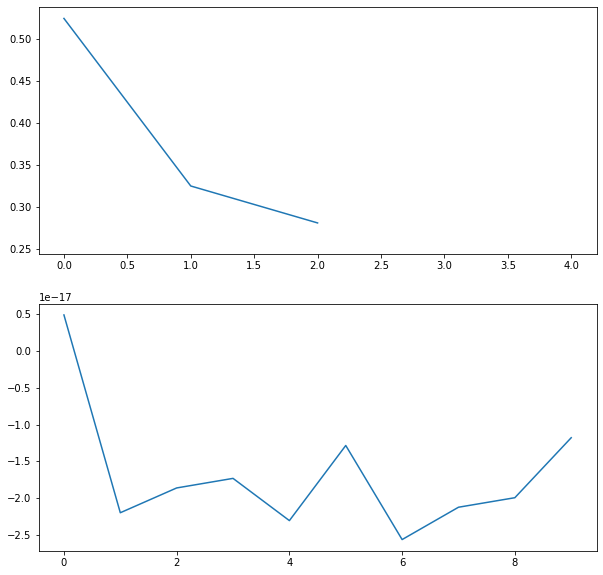

In [13]:
# Adam
mlp.clear_history()
mlp.W, mlp.B = W, B
mlp.opt = dl2.Adam(mlp.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), mlp.fit(x_train_MLP, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(mlp, x_test_MLP, y_test_oh)} %')

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:02<00:00, 965.54it/s]


accuracy - 96.35 %


<Figure size 720x720 with 0 Axes>

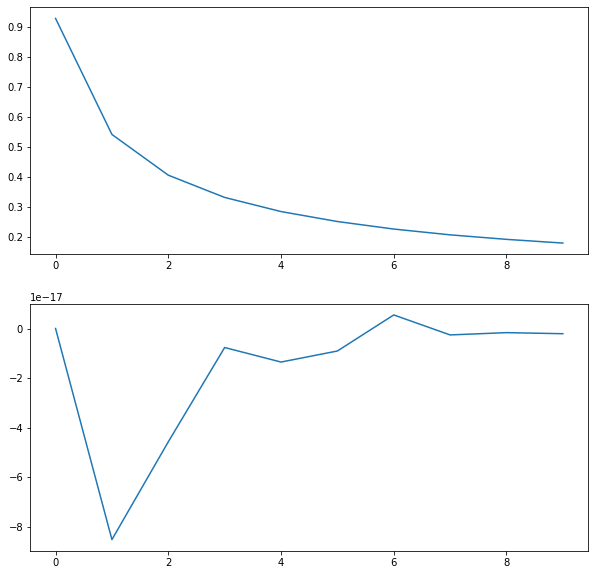

In [14]:
# Adagrad
mlp.clear_history()
mlp.W, mlp.B = W, B
mlp.opt = dl2.Adagrad(mlp.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), mlp.fit(x_train_MLP, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(mlp, x_test_MLP, y_test_oh)} %')

### CNNs > MLPs at image recognition 
CNNs use feature maps and kernels $\implies$ less visual information is lost. The sparsely connected nature of CNNs make them less susceptible to overfitting. Below is an image of one of the very first few CNNs to be used for character recognition - LeNet-5. 

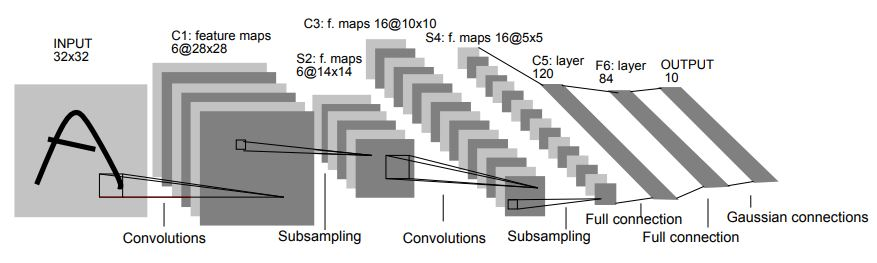

In [15]:
Image('LeNet-5.jpg')

The CNN model below has 13006 parameters - much less than the MLP we used before, but still a bit slower as the convolution operation is not optimized...

In [16]:
cnn = dl2.NN()
cnn.add(dl2.conv2d(filters=8, filters_dim=(2, 2), strides=(2, 2), activation='relu', input_dim=(28, 28, 1)))
cnn.add(dl2.conv2d(filters=8, filters_dim=(2, 2), strides=(2, 2), activation='relu'))
cnn.add(dl2.flatten())
cnn.add(dl2.dense(28, activation='relu'))
cnn.add(dl2.dense(10, activation='softmax'))
cnn.init()
cnn.info()

{'input_dim': (28, 28, 1), 'output_dim': (14, 14, 8), 'bias': True, 'filters': 8, 'filters_dim': (2, 2), 'strides': (2, 2), 'layer': 'conv2d', 'activation': 'relu'}
{'input_dim': (14, 14, 8), 'output_dim': (7, 7, 8), 'bias': True, 'filters': 8, 'filters_dim': (2, 2), 'strides': (2, 2), 'layer': 'conv2d', 'activation': 'relu'}
{'input_dim': (7, 7, 8), 'output_dim': 392, 'bias': True, 'layer': 'flatten', 'activation': 'none'}
{'input_dim': 392, 'output_dim': 28, 'layer': 'dense', 'activation': 'relu'}
{'input_dim': 28, 'output_dim': 10, 'layer': 'dense', 'activation': 'softmax'}
trainable parameters: 13934


In [17]:
W, B = cnn.W, cnn.B
cnn.loss_fn = 'ce'

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:03<00:00, 246.77it/s]


accuracy - 97.21 %


<Figure size 720x720 with 0 Axes>

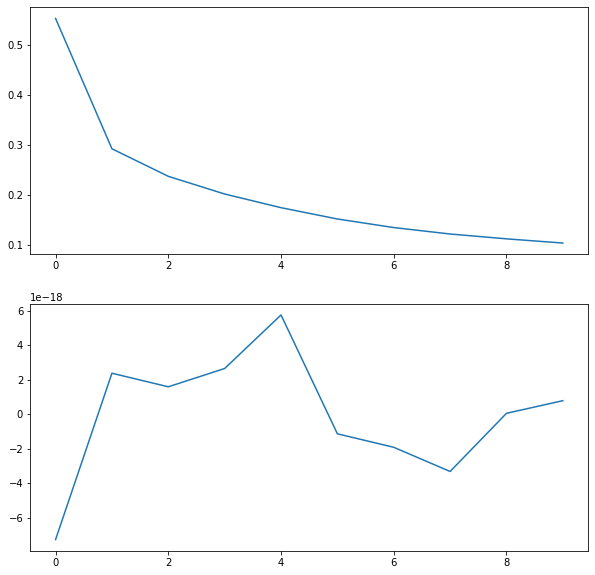

In [18]:
# Batch GD
cnn.clear_history()
cnn.W, cnn.B = W, B
cnn.opt = dl2.SGD(cnn.params(), 1e-2, 0)
plot(plt.figure(figsize=(10, 10)), cnn.fit(x_train_CNN, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(cnn, x_test_CNN, y_test_oh)} %')

 16%|████████████▎                                                               | 9677/60000 [00:39<03:17, 255.40it/s]C:\Users\rgbka\Desktop\Projects\dl2.py:462: RuntimeWarning: divide by zero encountered in log
  return - y * np.log(self.L[-1]) - (1 - y) * np.log(1 - self.L[-1])
C:\Users\rgbka\Desktop\Projects\dl2.py:462: RuntimeWarning: invalid value encountered in multiply
  return - y * np.log(self.L[-1]) - (1 - y) * np.log(1 - self.L[-1])
100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:02<00:00, 247.65it/s]


accuracy - 85.11 %


<Figure size 720x720 with 0 Axes>

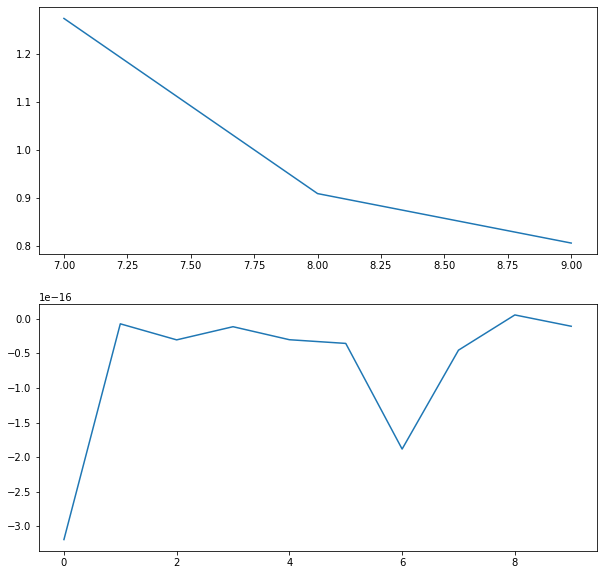

In [19]:
# Momentum
cnn.clear_history()
cnn.W, cnn.B = W, B
cnn.opt = dl2.SGD(cnn.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), cnn.fit(x_train_CNN, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(cnn, x_test_CNN, y_test_oh)} %')

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:03<00:00, 246.41it/s]


accuracy - 85.82 %


<Figure size 720x720 with 0 Axes>

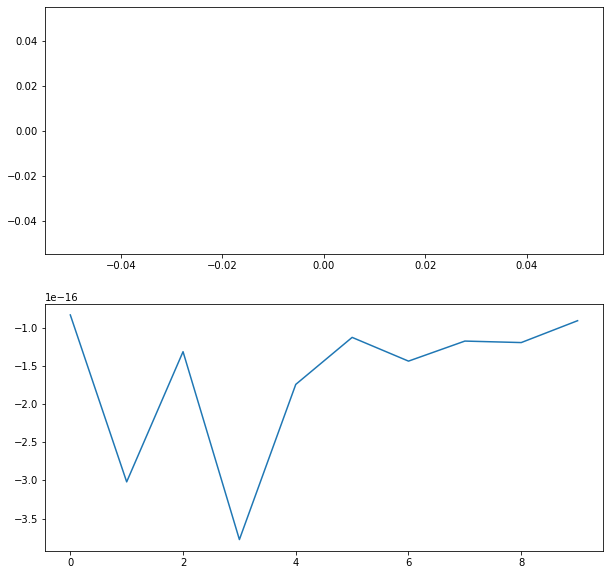

In [20]:
# RMSprop
cnn.clear_history()
cnn.W, cnn.B = W, B
cnn.opt = dl2.RMSprop(cnn.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), cnn.fit(x_train_CNN, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(cnn, x_test_CNN, y_test_oh)} %')

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:03<00:00, 246.68it/s]


accuracy - 95.71 %


<Figure size 720x720 with 0 Axes>

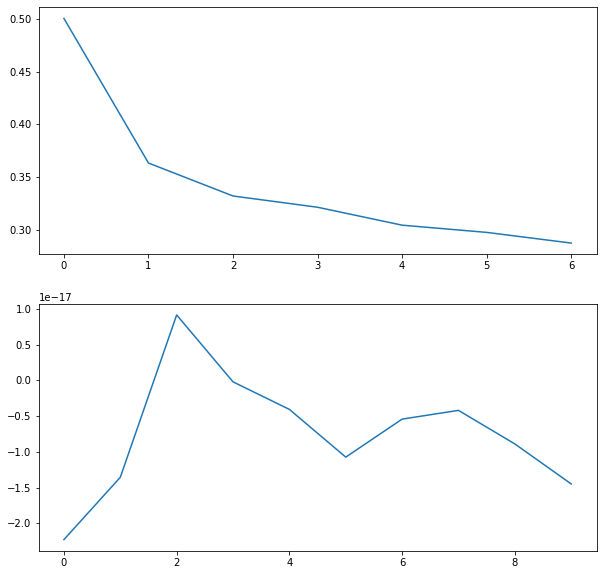

In [21]:
# Adam
cnn.clear_history()
cnn.W, cnn.B = W, B
cnn.opt = dl2.Adam(cnn.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), cnn.fit(x_train_CNN, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(cnn, x_test_CNN, y_test_oh)} %')

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [04:04<00:00, 245.68it/s]


accuracy - 97.08 %


<Figure size 720x720 with 0 Axes>

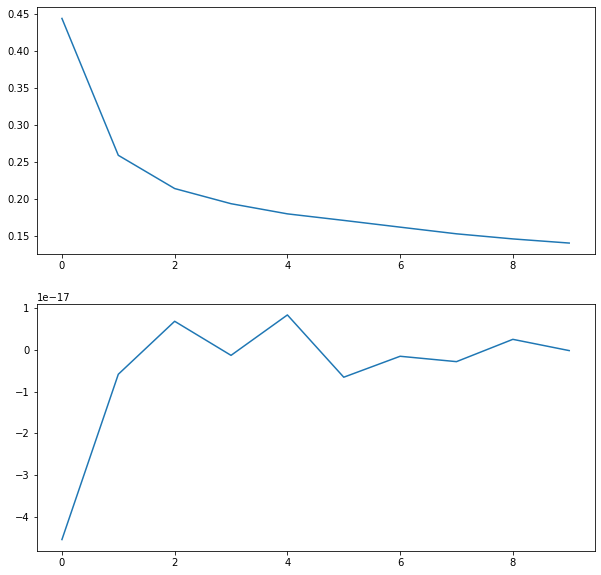

In [22]:
# Adagrad
cnn.clear_history()
cnn.W, cnn.B = W, B
cnn.opt = dl2.Adagrad(cnn.params(), 1e-2)
plot(plt.figure(figsize=(10, 10)), cnn.fit(x_train_CNN, y_train_oh, epochs=10, batch_size=50))
print(f'accuracy - {dl2.accuracy(cnn, x_test_CNN, y_test_oh)} %')

### Visualizing MLP weights and gradients

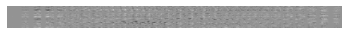

In [23]:
plt.axis('off')
plt.imshow(mlp.W[0], cmap='gray')

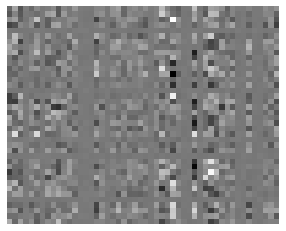

In [24]:
plt.axis('off')
plt.imshow(mlp.W[1], cmap='gray')

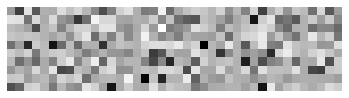

In [25]:
plt.axis('off')
plt.imshow(mlp.W[2], cmap='gray')

### Visualizing CNN filters, weights and gradients

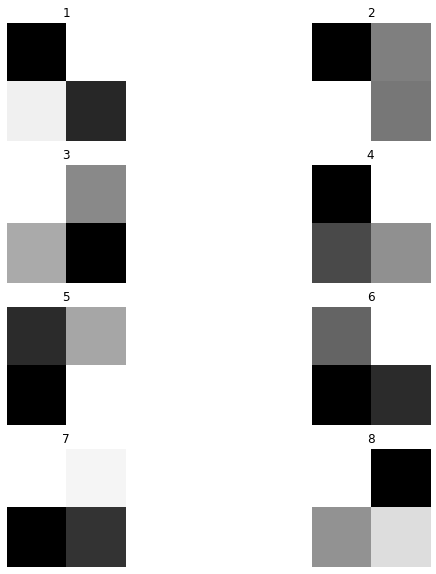

In [26]:
filters = cnn.W[0]
fig = plt.figure(figsize=(10, 10))
for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.title(f'{i + 1}')
    plt.axis('off')
    plt.imshow(filters[i][:, :, 0], cmap='gray')
plt.show()

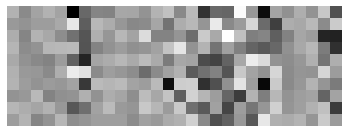

In [27]:
plt.axis('off')
plt.imshow(cnn.W[-1], cmap='gray')